In [ ]:
##
## Keith Loritz 2023AUG11
##
## Modified code for visualizing our starting dataset as
## produce per Todd's blog data https://antibody-engineers.org/blog/immunoprofiling-resources
## I began with a copy of what Todd had provided the team and made small improvements in being able to zoom in on the data
## to see what was causing artifact/aliasing of the plots.
## Most of what I saw as concerns in the plotted data not being consistant had to do with interpolation of the 
## plotting software
##
## There were many dataframe elements that had empty fields (a.k.a. "NaN", "None")
## Once I was able to eliminate these sequences, I felt confident that moving forward would cleaning the data using
## methods and concepts we discussed as a team would be "more accurate" (but not necessarily significant in the big scheme of things).
##
## Below, I utilized programming constructs I had learned at UCI in my AI/Machine Learning courses to add live/interactive plotting features
## to zoom in on regions of interest of the plots and select subsets of data
##
## I was able to prove to myself that the inconsistancies I saw in the plots were due to interpolation/compression of the output data
## and having alternative (not T or F) elements in the source data
##
## My next steps would be to continue looking into different methods to compress and display the data, similar to what Todd had
## shown with his D50 data manipulation/plotting
##

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di 
from ipywidgets import interact, widgets, interactive
import seaborn as sns
from Bio import pairwise2, SeqIO, Phylo
from Bio.Align import substitution_matrices
from Bio.Seq import Seq
from Bio.Align import MultipleSeqAlignment
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input').toggle();">Toggle code</button>''', raw=True)

path = ''

Toggle code

In [4]:
# load the data
df = pd.read_csv(path + 'BLAST_RESULTS',sep='\t')

In [5]:
##list all column headings
list(df)

['sequence_id',
 'sequence',
 'sequence_aa',
 'locus',
 'stop_codon',
 'vj_in_frame',
 'v_frameshift',
 'productive',
 'rev_comp',
 'complete_vdj',
 'd_frame',
 'v_call',
 'd_call',
 'j_call',
 'sequence_alignment',
 'germline_alignment',
 'sequence_alignment_aa',
 'germline_alignment_aa',
 'v_alignment_start',
 'v_alignment_end',
 'd_alignment_start',
 'd_alignment_end',
 'j_alignment_start',
 'j_alignment_end',
 'v_sequence_alignment',
 'v_sequence_alignment_aa',
 'v_germline_alignment',
 'v_germline_alignment_aa',
 'd_sequence_alignment',
 'd_sequence_alignment_aa',
 'd_germline_alignment',
 'd_germline_alignment_aa',
 'j_sequence_alignment',
 'j_sequence_alignment_aa',
 'j_germline_alignment',
 'j_germline_alignment_aa',
 'fwr1',
 'fwr1_aa',
 'cdr1',
 'cdr1_aa',
 'fwr2',
 'fwr2_aa',
 'cdr2',
 'cdr2_aa',
 'fwr3',
 'fwr3_aa',
 'fwr4',
 'fwr4_aa',
 'cdr3',
 'cdr3_aa',
 'junction',
 'junction_length',
 'junction_aa',
 'junction_aa_length',
 'v_score',
 'd_score',
 'j_score',
 'v_cigar'

In [6]:
print(len(df)," rows/records")
print(df.shape[1], "data columns")

1143810  rows/records
96 data columns


In [7]:
# add a new column with the length of the sequences 
df['seq_len'] = df['sequence'].apply(len)
seq_len_counts = df['seq_len'].value_counts()
seq_len_counts = seq_len_counts.sort_index()

In [10]:
def Example2(viewProductiveSwitch,center,span):
    
    x_low_limit = center - span/2
    x_hi_limit = center + span/2
    
    
    # Filter the data where switch is 'ALL' or 'productive' is 'T'/'F'
    if(viewProductiveSwitch == 'ALL'):
        selected_df = df[df['productive'] != 'q']
    else:
        selected_df = df[df['productive'] == viewProductiveSwitch]
    
    # Count the occurrences of each sequence length for productive and non-productive sequences
    selected_seq_len_counts = selected_df['seq_len'].value_counts().sort_index()
    
    # Create a 1x2 subplot layout
    fig = plt.figure(figsize=(16,6))
    
    # Plot the distribution of sequence lengths for all sequences
    seq_len_counts = df['seq_len'].value_counts()
    seq_len_counts = seq_len_counts.sort_index()
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_xlabel('Sequence Length')
    ax1.set_ylabel('Count')
    ax1.bar(seq_len_counts.index, seq_len_counts.values, color='blue',)
    plt.title('Distribution of Sequence Lengths for ALL Sequences')
    ax1.grid()
    ax1.set_xlim(x_low_limit,x_hi_limit)
    
    # Plot the distribution of sequence lengths for non-productive sequences
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_xlabel('Sequence Length')
    ax2.set_ylabel('Count')
    ax2.bar(selected_seq_len_counts.index, selected_seq_len_counts.values, color='red')
    plt.title("Distribution of Sequence Lengths for Selected '" + viewProductiveSwitch + "' Sequences")
    ax2.grid()
    ax2.set_xlim(x_low_limit,x_hi_limit)

    xlim_auto_ax1 = ax1.get_xlim()
    xlim_auto_ax2 = ax2.get_xlim()
    
    ax1.set_xlim(xlim_auto_ax1)
    ax2.set_xlim(xlim_auto_ax1)
    
    ylim_auto_ax1 = ax1.get_ylim()
    ylim_auto_ax2 = ax2.get_ylim()

    ax1.set_ylim(ylim_auto_ax1)
    ax2.set_ylim(ylim_auto_ax1)

    plt.tight_layout()
    plt.show()

In [11]:
pl = interactive(Example2, viewProductiveSwitch = widgets.Dropdown(value = 'T', options = ['T', 'F', 'ALL'], description = 'View Productive:'),
                 center = widgets.IntSlider(value = 300, min = 1, max = 650, step = 1, description = ' X Axis Center: ', continuous_update = False),
                 span = widgets.IntSlider(value = 600, min = 2, max = 650, step = 1, description = ' X Axis Span: ', continuous_update = False))
display(pl)

interactive(children=(Dropdown(description='View Productive:', options=('T', 'F', 'ALL'), value='T'), IntSlide…

In [12]:
def Example3(center,span):
    
    x_low_limit = center - span/2
    x_hi_limit = center + span/2
    
    productive_df = df[df['productive'] == 'T']
    non_productive_df = df[df['productive'] == 'F']
    other_productive_df = df[df['productive'].isna()]

    # Count the occurrences of each sequence length for productive and non-productive sequences
    productive_seq_len_counts = productive_df['seq_len'].value_counts().sort_index()
    non_productive_seq_len_counts = non_productive_df['seq_len'].value_counts().sort_index()
    other_productive_seq_len_counts = other_productive_df['seq_len'].value_counts().sort_index()

    # Create a 1x1 subplot layout
    fig = plt.figure(figsize=(16,6))
    
    # Plot the distribution of sequence lengths for all sequences
    seq_len_counts = df['seq_len'].value_counts()
    seq_len_counts = seq_len_counts.sort_index()
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel('Sequence Length')
    ax.set_ylabel('Count')
    ax.bar(productive_seq_len_counts.index, productive_seq_len_counts.values, color='green',label='Productive')
    ax.bar(non_productive_seq_len_counts.index, non_productive_seq_len_counts.values, color='red',label='Non-Productive')
    ax.bar(other_productive_seq_len_counts.index, other_productive_seq_len_counts.values, color='yellow',label='Undefined')
    plt.title('Distribution of Sequence Lengthss')
    ax.legend()
    ax.grid()
    ax.set_xlim(x_low_limit,x_hi_limit)
    
    xlim_auto_ax = ax.get_xlim()
     
    ax.set_xlim(xlim_auto_ax)
    
    ylim_auto_ax = ax.get_ylim()

    ax.set_ylim(ylim_auto_ax)

    plt.show()

In [13]:
pl = interactive(Example3, center = widgets.IntSlider(value = 300, min = 1, max = 650, step = 1, description = ' X Axis Center: ', continuous_update = False),
                 span = widgets.IntSlider(value = 600, min = 2, max = 650, step = 1, description = ' X Axis Span: ', continuous_update = False))
display(pl)

interactive(children=(IntSlider(value=300, continuous_update=False, description=' X Axis Center: ', max=650, m…

In [14]:
columns_to_count = ['fwr1_aa', 'cdr1_aa', 'fwr2_aa', 'cdr2_aa', 'fwr3_aa', 'fwr4_aa', 'cdr3_aa']

prod_df=df[df['productive'] == 'T'] #global filter

for column in columns_to_count:
    counts = prod_df[column].value_counts()
    print(f"Value counts for column '{column}':")
    print(counts)
    print(f"Total: '{prod_df.shape[0]}'")
    print("-----------------------")

Value counts for column 'fwr1_aa':
fwr1_aa
DIQMTQSPSSLSASVGDRVTITCRAS    51043
QSALTQPASVSGSPGQSITISCTGT     42758
EIVLTQSPGTLSLSPGERATLSCRAS    29642
DIVMTQSPDSLAVSLGERATINCKSS    28928
EIVLTQSPATLSLSPGERATLSCRAS    25195
                              ...  
QLVLTPSPSASASLGASVKLTCTLN         1
EVHLLESGGGLVQPGGSLRLSCVAA         1
DIPMTQSPSSLSAFVGDRVTITFRAN        1
VVLTQSPVSLAVALGQSVSISCRSA         1
EVQLLESGGGFVKPGGSLRLSCAAP         1
Name: count, Length: 67284, dtype: int64
Total: '963708'
-----------------------
Value counts for column 'cdr1_aa':
cdr1_aa
SSDVGGYNY       34714
QSISSY          30443
QSVSSSY         25673
QSVSSN          24718
QSVSSY          23637
                ...  
KGISSG              1
QNINMR              1
QSGWASSNNKNY        1
SCDLCGFNY           1
GFXFSTXW            1
Name: count, Length: 37124, dtype: int64
Total: '963708'
-----------------------
Value counts for column 'fwr2_aa':
fwr2_aa
LAWYQQKPGQAPRLLIY    87592
LNWYQQKPGKAPKLLIY    43307
VSWYQQHPGKAPKLMIY

In [15]:
protein_sequences = df['fwr1_aa'].tolist()
cleaned_protein_sequences = [value for value in protein_sequences if isinstance(value, str)]


# Create Bio.Seq objects from the sequences
seq_objects = [Seq(seq) for seq in cleaned_protein_sequences]

print(len(seq_objects))

matrix = substitution_matrices.load("BLOSUM62")
alignments = pairwise2.align.globalds(seq_objects[0], seq_objects[1], matrix, -10, -0.5)

print(seq_objects[0])
print(seq_objects[1])
print(matrix)
# Process alignment results, e.g., calculate sequence identity
aligned_seq1, aligned_seq2, score, start, end = alignments[0]
sequence_identity = (score / len(aligned_seq1)) * 100

print("Sequence Identity:", sequence_identity)
aligned_seq1, aligned_seq2, score, start, end

997113
DIQMTQSPSSLSASVGDRVTITCQAS
QSALTQPASVSGSPGQSVTISCTGT
#  Matrix made by matblas from blosum62.iij
#  * column uses minimum score
#  BLOSUM Clustered Scoring Matrix in 1/2 Bit Units
#  Blocks Database = /data/blocks_5.0/blocks.dat
#  Cluster Percentage: >= 62
#  Entropy =   0.6979, Expected =  -0.5209
     A    R    N    D    C    Q    E    G    H    I    L    K    M    F    P    S    T    W    Y    V    B    Z    X    *
A  4.0 -1.0 -2.0 -2.0  0.0 -1.0 -1.0  0.0 -2.0 -1.0 -1.0 -1.0 -1.0 -2.0 -1.0  1.0  0.0 -3.0 -2.0  0.0 -2.0 -1.0  0.0 -4.0
R -1.0  5.0  0.0 -2.0 -3.0  1.0  0.0 -2.0  0.0 -3.0 -2.0  2.0 -1.0 -3.0 -2.0 -1.0 -1.0 -3.0 -2.0 -3.0 -1.0  0.0 -1.0 -4.0
N -2.0  0.0  6.0  1.0 -3.0  0.0  0.0  0.0  1.0 -3.0 -3.0  0.0 -2.0 -3.0 -2.0  1.0  0.0 -4.0 -2.0 -3.0  3.0  0.0 -1.0 -4.0
D -2.0 -2.0  1.0  6.0 -3.0  0.0  2.0 -1.0 -1.0 -3.0 -4.0 -1.0 -3.0 -3.0 -1.0  0.0 -1.0 -4.0 -3.0 -3.0  4.0  1.0 -1.0 -4.0
C  0.0 -3.0 -3.0 -3.0  9.0 -3.0 -4.0 -3.0 -3.0 -1.0 -1.0 -3.0 -1.0 -2.0 -3.0 -1.0 

('DIQMTQSPSSLSASVGDRVTITCQAS', 'QSALTQ-PASVSGSPGQSVTISCTGT', 46.0, 0, 26)

In [18]:
## Notes by Keith Loritz 20232AUG11
## In development, do not run, not beneficial for producing anything in a reasonable amount of time.
## After submitting this notebook cell, and letting it run for about two hours, and not seeing any progress, I stopped running it.
## It might be appropriate to see if any of this code could be run in a "verbose" mode to monitor its progress.

## There is where my journey stalled during the last few hours at the very end of the 2023 hackathon
## Although pylogenetic trees are excellent visualization tools, it may not be appropriate in this case.
## Given that there are almost 1,000,000 fwr1_aa amino acid sequences in the dataframe
## this would require significant time to run, perhaps months of CPU time.

## If desiring to utilize this code as a learning tool, it might be appropriate to both highly reduce the amount of data, perhaps down to about 25 sequences to start
## and find a more constant amino acid sequence, perhaps in the Fc regions.

## Finally, the phylogenetic tree might be better utilized to watch the immune system evolve over time when many time point samples have been sequenced.

## Most of this code was provided by ChatGPT with corrections, modifications and updates to make it work in this instance. 
## Our leadership was not convinced of its utility for this hackathon. I was not granted the
## ability to load ete3 into our "VM" configuration for using here "# You need to install ETE Toolkit: pip install ete3"
##

## I was thinking that this code might be appropriate to implement/use with some of the "sample" reads
## from the UCI research lab I am affiliated with. I may try to implement it using several different hardware
## platforms to hopefully obtain performance metrics of Jetstream2 (64 cpu), my i9 home desktop (24 cores), my 2014 mac book pro 11.3 (dual core i7 processor)











## from above seq_objects = [Seq(seq) for seq in sequences]

# Perform pairwise sequence alignments
##alignment = MultipleSeqAlignment(
    [pairwise2.align.globalxx(seq1, seq2)[0] for seq1 in seq_objects for seq2 in seq_objects]
)

# Calculate pairwise distances
calculator = DistanceCalculator("identity")
dm = calculator.get_distance(alignment)

# Construct a neighbor-joining tree
constructor = DistanceTreeConstructor()
tree = constructor.nj(dm)

# Save the tree to a file (in Newick format)
Phylo.write(tree, "protein_tree.nwk", "newick")

# Visualize the tree (requires ETE Toolkit)
# You need to install ETE Toolkit: pip install ete3
# tree = Phylo.read("protein_tree.nwk", "newick")
# Phylo.draw(tree)

KeyboardInterrupt: 

In [147]:
## Everything from here downwards should be as copied from Todd's starting point as of 2023AUG09












import seaborn as sns
columns_to_count = ['fwr1_aa', 'cdr1_aa', 'fwr2_aa', 'cdr2_aa', 'fwr3_aa', 'fwr4_aa', 'cdr3_aa']

df[df['productive'] == 'T']

for column in columns_to_count:
    # Calculate the value counts for the column
    counts = df[column].value_counts()
    # Filter the value counts for values greater than 1
    filtered_counts = counts[counts > 10]
    diversity = filtered_counts.shape[0]
    
    print(f"Filtered value counts for column '{column}':")
    print(diversity)
    print("-----------------------")

Filtered value counts for column 'fwr1_aa':
7338
-----------------------
Filtered value counts for column 'cdr1_aa':
8073
-----------------------
Filtered value counts for column 'fwr2_aa':
7702
-----------------------
Filtered value counts for column 'cdr2_aa':
3782
-----------------------
Filtered value counts for column 'fwr3_aa':
11646
-----------------------
Filtered value counts for column 'fwr4_aa':
2070
-----------------------
Filtered value counts for column 'cdr3_aa':
15276
-----------------------


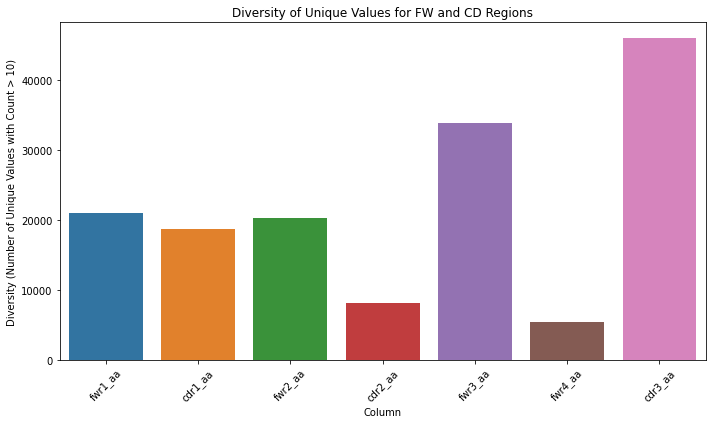

In [148]:
# Assuming 'df' is your pandas DataFrame containing the columns 'fwr1_aa', 'cdr1_aa', 'fwr2_aa', 'cdr2_aa', 'fwr3_aa', 'fwr4_aa', and 'cdr3_aa'

columns_to_count = ['fwr1_aa', 'cdr1_aa', 'fwr2_aa', 'cdr2_aa', 'fwr3_aa', 'fwr4_aa', 'cdr3_aa']

# Initialize lists to store the column names and their respective diversities
column_names = []
diversities = []

for column in columns_to_count:
    # Calculate the value counts for the column
    counts = df[column].value_counts()
    # Filter the value counts for values greater than 10
    filtered_counts = counts[counts > 1]
    # Calculate the diversity (number of unique values with count > 10)
    diversity = filtered_counts.shape[0]
    
    # Append column name and diversity to the lists
    column_names.append(column)
    diversities.append(diversity)

# Create the bar plot for column names and their diversities
plt.figure(figsize=(10, 6))
sns.barplot(x=column_names, y=diversities)
plt.xlabel('Column')
plt.ylabel('Diversity (Number of Unique Values with Count > 10)')
plt.title('Diversity of Unique Values for FW and CD Regions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'df' is your pandas DataFrame containing the columns 'fwr1_aa', 'cdr1_aa', 'fwr2_aa', 'cdr2_aa', 'fwr3_aa', 'fwr4_aa', and 'cdr3_aa'

columns_to_count = ['fwr1_aa', 'cdr1_aa', 'fwr2_aa', 'cdr2_aa', 'fwr3_aa', 'fwr4_aa', 'cdr3_aa']

# Initialize lists to store the column names and their respective diversities
column_names = []
diversities = []

# Precompute the histogram data for each column
hist_data = {}
for column in columns_to_count:
    # Calculate the value counts for the column
    counts = df[column].value_counts()
    # Filter the value counts for values greater than 1
    filtered_counts = counts[counts > 10]
    # Calculate the diversity (number of unique values with count > 1)
    diversity = filtered_counts.shape[0]
    
    # Append column name and diversity to the lists
    column_names.append(column)
    diversities.append(diversity)

    # Precompute the histogram data using value_counts() and store it in hist_data dictionary
    hist_data[column] = filtered_counts.values

# Get the common ymax value (maximum value across all histograms)
all_values = [value for column_values in hist_data.values() for value in column_values]
ymax = max(all_values)

# Plot histograms for each column with 10 bins on log scale with the common ymax
num_rows = len(columns_to_count) // 3 + 1
plt.figure(figsize=(15, 12))
for i, column in enumerate(columns_to_count):
    plt.subplot(num_rows, 3, i + 1)
    values = hist_data[column]
    plt.hist(values, bins=10)
    plt.yscale('log')  # Set y-axis to log scale
    plt.xlabel('Value')
    plt.ylabel('Frequency (log scale)')
    plt.title(f'Histogram for {column}')
    #plt.ylim(0.1, ymax * 10)  # Set the common ymax value for all subplots
    
plt.tight_layout()
plt.show()

In [ ]:
# Assuming 'prod_df' is your filtered DataFrame containing the columns 'fwr1_aa', 'cdr1_aa', 'fwr2_aa', 'cdr2_aa', 'fwr3_aa', 'fwr4_aa', and 'cdr3_aa'
columns_to_count = ['fwr1_aa', 'cdr1_aa', 'fwr2_aa', 'cdr2_aa', 'fwr3_aa', 'fwr4_aa', 'cdr3_aa']

# Calculate the total number of rows in the DataFrame
total_rows = prod_df.shape[0]

# Loop through each column and calculate value counts and fractions
for column in columns_to_count:
    # Calculate the value counts for the column
    counts = prod_df[column].value_counts()
    # Calculate the fraction (percentage) of each value in the column
    frac = counts / total_rows
    # Combine the counts and fractions into a DataFrame
    result_df = pd.DataFrame({'sequence': counts.index, 'number': counts.values, 'frac': frac.values})
    # Print the table for the current column
    print(f"Table for column '{column}':")
    print(result_df)
    print("-----------------------")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'prod_df' is your filtered DataFrame containing the columns 'fwr1_aa', 'cdr1_aa', 'fwr2_aa', 'cdr2_aa', 'fwr3_aa', 'fwr4_aa', and 'cdr3_aa'
columns_to_count = ['fwr1_aa', 'cdr1_aa', 'fwr2_aa', 'cdr2_aa', 'fwr3_aa', 'fwr4_aa', 'cdr3_aa']

# Calculate the total number of rows in the DataFrame
total_rows = prod_df.shape[0]

# Set the filter threshold for cumulative sum of 'frac'
filter_threshold = 0.7

# Initialize a list to store the counts of rows where sum of 'frac' >= 0.9
rows_90percent = []

# Loop through each column and calculate value counts and fractions
for column in columns_to_count:
    # Calculate the value counts for the column
    counts = prod_df[column].value_counts()
    # Calculate the fraction (percentage) of each value in the column
    frac = counts / total_rows
    # Combine the counts and fractions into a DataFrame
    result_df = pd.DataFrame({'sequence': counts.index, 'number': counts.values, 'frac': frac.values})
    
    # Calculate the cumulative sum of 'frac'
    cumsum = result_df['frac'].cumsum()
    
    # Filter the rows where the cumulative sum is less than or equal to the filter threshold
    filtered_rows = result_df[cumsum <= filter_threshold]
    
    # Count the number of rows that satisfy the condition
    rows_90 = filtered_rows.shape[0]
    rows_90percent.append(rows_90)

# Create a bar plot for the count of rows that account for 90% of data in each column
plt.figure(figsize=(10, 6))
plt.bar(columns_to_count, rows_90percent)
plt.xlabel('Column')
plt.ylabel('Number of Rows (90% of data)')
plt.title(f'Number of Rows Accounting for {int(filter_threshold*100)}% of Data in Each Column')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'prod_df' is your filtered DataFrame containing the columns 'fwr1_aa', 'cdr1_aa', 'fwr2_aa', 'cdr2_aa', 'fwr3_aa', 'fwr4_aa', and 'cdr3_aa'
columns_to_count = ['fwr1_aa', 'cdr1_aa', 'fwr2_aa', 'cdr2_aa', 'fwr3_aa', 'fwr4_aa', 'cdr3_aa']

# Calculate the total number of rows in the DataFrame
total_rows = prod_df.shape[0]

# Set the filter threshold (fraction sum)
filter_threshold = 0.6

# Initialize a list to store the counts of rows where sum of 'frac' >= filter_threshold
rows_filter_percent = []

# Initialize a list to store the violin plot data
violin_data_list = []

# Loop through each column and calculate value counts and fractions
for column in columns_to_count:
    # Calculate the value counts for the column
    counts = prod_df[column].value_counts()
    # Calculate the fraction (percentage) of each value in the column
    frac = counts / total_rows
    # Combine the counts and fractions into a DataFrame
    result_df = pd.DataFrame({'sequence': counts.index, 'number': counts.values, 'frac': frac.values})
    
    # Calculate the cumulative sum of 'frac'
    cumsum = result_df['frac'].cumsum()
    
    # Filter the rows where the cumulative sum is less than or equal to the filter_threshold
    filtered_rows = result_df[cumsum <= filter_threshold]
    
    # Count the number of rows that satisfy the condition
    rows_filtered = len(filtered_rows)
    rows_filter_percent.append(rows_filtered)

    # Append the 'number' values to the violin data list
    violin_data_list.append(counts)
    print(column)
    print(f"total_rows {counts.shape[0]}")
    print(f"filtered_rows {rows_filtered}\n")
    

# Create the violin plot for 'number' values
plt.figure(figsize=(10, 6))
sns.violinplot(data=violin_data_list)
plt.xlabel('Column')
plt.ylabel('Number of Rows')
plt.title(f'Distribution of Number of Rows in Each Counts Table (Threshold: {filter_threshold * 100}%)')
plt.xticks(ticks=range(len(columns_to_count)), labels=columns_to_count, rotation=45)
plt.tight_layout()
plt.show()
